# First RNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Sequence

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
train_data = pd.read_csv("/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/train.csv")
test_data = pd.read_csv("/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/test.csv")

## Data preprocessing

In [227]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

## lists of features:


# f_time = ['time']


## our custom functions:

def log_transformed(data):
    """ replaces values in columns in a dataframe with the log values """
    f_logs = [
    'precip_1h:mm',
    'prob_precip_1h:p',
    'clear_sky_rad:W',
    'clear_sky_energy_1h:J',
    'diffuse_rad:W',
    'diffuse_rad_1h:Wh',
    'direct_rad:W',
    'direct_rad_1h:Wh',
    'global_rad:W',
    'global_rad_1h:Wh',
    'wind_speed_2m:ms',
    'wind_speed_10m:ms',
    'wind_speed_50m:ms',
    'wind_speed_100m:ms'
]
    for col in f_logs:
        data[col] = np.log(data[col] + 1e-5)
    return data

def time_transformed(data):
    """takes a df and splits the 'time' feature into three features: hour, month, season;
    drops the original time column"""

    feature = pd.to_datetime(data.time)

    hour = feature.dt.hour
    month  = feature.dt.month

    def assign_season(month):
        if month in [3, 4, 5]:
            return 1  # Spring
        elif month in [6, 7, 8]:
            return 2  # Summer
        elif month in [9, 10, 11]:
            return 3  # Fall
        else:  # December, January, February
            return 4  # Winter

    season = month.apply(assign_season)
    hour_sine = np.sin(2 * np.pi * hour / 24)
    hour_cosine = np.cos(2 * np.pi * hour / 24)
    month_sine = np.sin(2 * np.pi * month / 12)
    month_cosine = np.cos(2 * np.pi * month / 12)
    season_sine = np.sin(2 * np.pi * season / 4)
    season_cosine = np.cos(2 * np.pi * season / 4)

    data["hour_sine"] = hour_sine
    data["hour_cosine"] = hour_cosine
    data["month_sine"] = month_sine
    data["month_cosine"] = month_cosine
    data["season_sine"] = season_sine
    data["season_cosine"] = season_cosine

    data = data.drop(columns=["time"])

    return data

def degree_transformed(data):
    """ takes a df 'data' and takes the features with degree units (in the specific list f_degree);
    creates a sin and cos column for each to make them cyclical. drops the original columns"""

    f_degree = ['sun_azimuth:d', 'wind_dir_2m:d', 'wind_dir_10m:d', 'wind_dir_50m:d', 'wind_dir_100m:d']

    for col in f_degree:
        sin_column = np.sin(2 * np.pi * data[col]/360)
        cos_column = np.cos(2 * np.pi * data[col]/360)

        data[f"sin_{col}"] = sin_column
        data[f"cos_{col}"] = cos_column
        data = data.drop(columns=[col])

    return data

def transform_data(data):
    """ applies the above three functions to the input dataframe """
    data = degree_transformed(time_transformed(log_transformed(data)))

    all_col = list(data.columns)

    # defining the columns we don't want in our X_train
    drop_col = ['pv_production',
            'wind_production',
            'consumption',
            'spot_market_price',
            'precip_type:idx']

    f_ohe = ['precip_type:idx']

    scale_col = [col for col in all_col if col not in drop_col and f_ohe]

    # defining our scalers
    minmax = MinMaxScaler()
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output = False)


    # our preproc pipline
    preproc = make_column_transformer(
        (ohe, f_ohe),
        (minmax, scale_col),
        remainder = "drop"
    )

    data_transformed = preproc.fit_transform(data)
    data_transformed = pd.DataFrame(data_transformed, columns=preproc.get_feature_names_out())
    data_transformed['onehotencoder__precip_type:idx_2.0'] = 0

    print('➡️ preprocessing done')
    return data_transformed



# ## building the pipeline

# data = pd.read_csv("raw_data/train.csv")

# # calling our custom functions on our dataframe
# data_ft = degree_transformed(time_transformed(log_transformed(data)))

# all_col = list(data_ft.columns)

# # defining the columns we don't want in our X_train
# drop_col = ['pv_production',
#             'wind_production',
#             'consumption',
#             'spot_market_price',
#             'precip_type:idx']

# # defining the columns we want to scale
# scale_col = [col for col in all_col if col not in drop_col and f_ohe]

# # defining our scalers
# minmax = MinMaxScaler()
# ohe = OneHotEncoder(handle_unknown='ignore', sparse_output = False)

# # our preproc pipline
# preproc = make_column_transformer(
#     (ohe, f_ohe),
#     (minmax, scale_col),
#     remainder = "drop"
# )

# data_transformed = preproc.fit_transform(data_ft)
# data_transformed = pd.DataFrame(data_transformed, columns=preproc.get_feature_names_out())


In [228]:
# creating y_train and y_test
y_train = train_data['pv_production'].copy()
y_test = test_data['pv_production'].copy()

# creating X_train and X_test
X_train = train_data
X_train = X_train.drop(columns=['pv_production', 'wind_production', 'consumption', 'spot_market_price'])
X_test = test_data
X_test = X_test.drop(columns=['pv_production', 'wind_production', 'consumption', 'spot_market_price'])

# Preprocessing features
X_train_transformed = transform_data(X_train)
X_test_transformed = transform_data(X_test)

➡️ preprocessing done
➡️ preprocessing done


In [124]:
X_test_transformed.shape

(841, 53)

In [229]:
TARGET = 'pv_production'

In [126]:
y_train.describe()

count    9515.000000
mean        7.654312
std        15.673519
min         0.000000
25%         0.000000
50%         0.000000
75%         6.411375
max        79.855834
Name: pv_production, dtype: float64

In [230]:
df = X_train_transformed.copy()

In [231]:
df[TARGET] = y_train

In [232]:
df.shape

(9515, 54)

### Wind feature importance

In [233]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [234]:
XG_X_train_transformed, XG_X_val, XG_y_train, XG_y_val = train_test_split(
X_train_transformed, y_train, test_size = 0.1, random_state = 42  # val = 10%
)

In [235]:
xgb_reg = XGBRegressor(
    max_depth=7,                # Optimal value found
    n_estimators=300,           # Optimal value found
    learning_rate=0.05,         # Optimal value found
    reg_alpha=0.05,             # Optimal value found
    reg_lambda=20,              # Optimal value found
    subsample=0.8,              # Optimal value found
    colsample_bytree=0.8,       # Optimal value found
    objective='reg:squarederror',
    eval_metric="mae",
    random_state=42             # Ensuring reproducibility
)

# Fit the model on the training data
xgb_reg.fit(
    XG_X_train_transformed,
    XG_y_train,
    eval_set=[(XG_X_train_transformed, XG_y_train), (XG_X_val, XG_y_val)],
    verbose=True,
    early_stopping_rounds=5     # Retain early stopping
)

print("➡️  model fitting done")

# Make predictions
y_pred = xgb_reg.predict(X_test_transformed)

print("➡️  performed predictions")

[0]	validation_0-mae:7.47285	validation_1-mae:6.73216
[1]	validation_0-mae:7.15147	validation_1-mae:6.45590
[2]	validation_0-mae:6.85235	validation_1-mae:6.19019


/Users/carlbechtolsheim/.pyenv/versions/3.10.6/envs/watt_squad/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mae:6.57044	validation_1-mae:5.94318
[4]	validation_0-mae:6.30595	validation_1-mae:5.71224
[5]	validation_0-mae:6.05732	validation_1-mae:5.50811
[6]	validation_0-mae:5.82059	validation_1-mae:5.31344
[7]	validation_0-mae:5.60057	validation_1-mae:5.13484
[8]	validation_0-mae:5.39475	validation_1-mae:4.96788
[9]	validation_0-mae:5.20249	validation_1-mae:4.81732
[10]	validation_0-mae:5.02190	validation_1-mae:4.68070
[11]	validation_0-mae:4.85558	validation_1-mae:4.55690
[12]	validation_0-mae:4.70233	validation_1-mae:4.43845
[13]	validation_0-mae:4.56206	validation_1-mae:4.32705
[14]	validation_0-mae:4.42592	validation_1-mae:4.22274
[15]	validation_0-mae:4.30253	validation_1-mae:4.13365
[16]	validation_0-mae:4.18660	validation_1-mae:4.05241
[17]	validation_0-mae:4.07856	validation_1-mae:3.98743
[18]	validation_0-mae:3.97860	validation_1-mae:3.91172
[19]	validation_0-mae:3.88108	validation_1-mae:3.84508
[20]	validation_0-mae:3.79132	validation_1-mae:3.78620
[21]	validation_0

In [237]:
importance = xgb_reg.feature_importances_
feature_names = X_train_transformed.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

In [238]:
importance_df

,Feature,Importance
12,minmaxscaler__global_rad:W,0.411079
10,minmaxscaler__direct_rad:W,0.219816
13,minmaxscaler__global_rad_1h:Wh,0.028506
44,minmaxscaler__cos_sun_azimuth:d,0.021546
8,minmaxscaler__diffuse_rad:W,0.017814
17,minmaxscaler__medium_cloud_cover:p,0.013041
37,minmaxscaler__hour_sine,0.010516
51,minmaxscaler__sin_wind_dir_100m:d,0.010082
38,minmaxscaler__hour_cosine,0.009273
40,minmaxscaler__month_cosine,0.008691


In [239]:
wind_columns_drop = list(importance_df[importance_df['Importance']<0.008]['Feature'])

In [240]:
len(wind_columns_drop)

40

In [241]:
df = df.drop(columns = wind_columns_drop).copy()

In [242]:
X_test_transformed = X_test_transformed.drop(columns = wind_columns_drop)

In [243]:
df.shape

(9515, 14)

In [244]:
X_test_transformed.shape

(841, 13)

## Prepare the dataset

### Folds

In [308]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 4 months      #
# (3 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 24 * 7 * 16                             # 24 times a day * for 7 days * for 16 weeks


# --------------------------------------------------- #
# Let's consider FOLDS starting every 2 weeks         #
# --------------------------------------------------- #

FOLD_STRIDE = 24 * 7 * 2                              # 24 times a day for 2 weeks


# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_VAL_RATIO = 0.75                               # 3 month train, 1 month test

In [ ]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Returns a list of folds, each as a DataFrame
    '''
    # YOUR CODE HERE
    folds = []
    for idx in range(0, len(df)-fold_length, fold_stride): # --> also possible to get rid of the break
    #for idx in range(0, len(df), fold_stride):   # range(start, stop, step): for each idx in our rows at every 91 days
        # Exits the loop as soon as the last fold index would exceed the last index
        #if (idx + fold_length) > len(df):
            #break
        fold = df.iloc[idx:idx + fold_length, :]  # select from row idx til last row of the fold (3 years), all the columns
        folds.append(fold)   # append the 3 year fold to folds
    return folds

### Train-Val split

In [ ]:
def train_val_split(fold:pd.DataFrame,
                     train_val_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    '''
    # YOUR CODE HERE
    # TRAIN SET
    # ======================
    last_train_idx = round(train_val_ratio * len(fold))  # 0.66 * number of rows in the fold (66% of the fold for train)
    fold_train = fold.iloc[0:last_train_idx, :]   # 1st until last row of train set, all columns

    # TEST SET
    # ======================
    first_val_idx = last_train_idx - input_length  # last row of train set - 2 weeks --> test set starts 2 weeks
                                                                    # before train set ends --> overlap (not a problem with X)
    fold_val = fold.iloc[first_val_idx:, :]   # 1st until last row of val set, all columns

    return (fold_train, fold_val)

In [ ]:
(fold_train, fold_val) = train_val_split(folds[0], TRAIN_VAL_RATIO, INPUT_LENGTH)

In [ ]:
#Five days as input & output length
INPUT_LENGTH = 24 * 5 # records every hour x 24 hours
                      # for 5 days
OUTPUT_LENGTH = 12

## Model

### Prepare dataset for model training

#### Train-Val split

In [142]:
def train_val_split(df:pd.DataFrame,
                     train_val_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    '''
    # YOUR CODE HERE
    # TRAIN SET
    # ======================
    last_train_idx = round(train_val_ratio * len(df))  # 0.66 * number of rows in the fold (66% of the fold for train)
    fold_train = df.iloc[0:last_train_idx, :]   # 1st until last row of train set, all columns

    # TEST SET
    # ======================
    first_val_idx = last_train_idx - input_length  # last row of train set - 2 weeks --> test set starts 2 weeks
                                                                    # before train set ends --> overlap (not a problem with X)
    fold_val = df.iloc[first_val_idx:, :]   # 1st until last row of val set, all columns

    return (fold_train, fold_val)

#### Sequences

In [143]:
def get_Xi_yi(
    df:pd.DataFrame,
    input_length:int,  # 120
    output_length:int,
    target: str
):  # 120
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # YOUR CODE
    first_possible_start = 0                                    # the +1 accounts for the index, that is exclusive.
    last_possible_start = len(df) - (input_length + output_length) + 1    # It can start as long as there are still
                                                                             # 120 + 12 days after the 1st day.
    random_start = np.random.randint(first_possible_start, last_possible_start)  # np.random to pick a day inside
                                                                                    # the possible interval.
    X_i = df.iloc[random_start:random_start+input_length]

    y_i = df.iloc[random_start+input_length:
                  random_start+input_length+output_length][target]  # creates a pd.DataFrame for the target y

    return (X_i, y_i)

In [144]:
def get_X_y(
    df:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int,
    target: str
):
    # YOUR CODE HERE
    X, y = [], []  # lists for the sequences for X and y

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(df, input_length, output_length, target)   # calls the previous function to generate sequences X + y
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)

In [212]:
#Five days as input & output length
INPUT_LENGTH = 24 * 5*2 # records every hour x 24 hours
                      # for 5 days
OUTPUT_LENGTH = 24

NUMBER_OF_SEQUENCES_TRAIN = int(len(df) * 0.9)
NUMBER_OF_SEQUENCES_VAL = int(len(df) * 0.1)

In [213]:
TRAIN_VAL_RATIO = 0.9
df_train, df_val = train_val_split(df, TRAIN_VAL_RATIO, INPUT_LENGTH)



In [214]:
X_train, y_train = get_X_y(df_train, NUMBER_OF_SEQUENCES_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH, TARGET)
X_val, y_val = get_X_y(df_val, NUMBER_OF_SEQUENCES_VAL, INPUT_LENGTH, OUTPUT_LENGTH, TARGET)


#Dropping the targets from the X (we dont want to train the model on the targets)
X_train = X_train[:, :, :-1]
X_val = X_val[:, :, :-1]

In [215]:
type(X_train)

numpy.ndarray

In [217]:
X_train.shape

(8563, 240, 13)

##### Show data

In [218]:
#Training set (splits the whole dataset into training and val set)
df_train.shape

(8564, 14)

In [219]:
#Validation set
df_val.shape

(1191, 14)

In [220]:
#Sequences of features of df_train (Splits the training set into smaller sequences with each shape of (120, 53))
# Train model on these features -> 53 features with 120 past hours
X_train.shape

(8563, 240, 13)

In [221]:
y_train = np.expand_dims(y_train, axis=-1)

In [222]:
#Sequences of corresponding targets of df_train (Splits the training set into smaller sequences with each shape of (120, 3))
# Train model on these targets -> 3 targets with 12 next hours
y_train.shape

(8563, 24, 1)

In [223]:
#Sequences of features of df_val (Splits the val set into 750 sequences with each shape of (120, 53))
X_val.shape

(951, 240, 13)

In [224]:
y_val = np.expand_dims(y_val, axis=-1)

In [225]:
#Sequences of corresponding targets of df_val (Splits the val set into 750 sequences with each shape of (120, 3))
y_val.shape

(951, 24, 1)

In [226]:
X_train.shape[1:]

(240, 13)

##### How do the dfs look like?

In [44]:
df_train

,onehotencoder__precip_type:idx_0.0,onehotencoder__precip_type:idx_1.0,onehotencoder__precip_type:idx_2.0,onehotencoder__precip_type:idx_3.0,minmaxscaler__precip_1h:mm,minmaxscaler__prob_precip_1h:p,minmaxscaler__clear_sky_rad:W,minmaxscaler__clear_sky_energy_1h:J,minmaxscaler__diffuse_rad:W,minmaxscaler__diffuse_rad_1h:Wh,...,minmaxscaler__cos_sun_azimuth:d,minmaxscaler__sin_wind_dir_2m:d,minmaxscaler__cos_wind_dir_2m:d,minmaxscaler__sin_wind_dir_10m:d,minmaxscaler__cos_wind_dir_10m:d,minmaxscaler__sin_wind_dir_50m:d,minmaxscaler__cos_wind_dir_50m:d,minmaxscaler__sin_wind_dir_100m:d,minmaxscaler__cos_wind_dir_100m:d,pv_production
0,1.0,0.0,0,0.0,0.0,0.0,0.757424,0.854846,0.781999,0.815432,...,0.038568,0.045382,0.291860,0.045382,0.291860,0.042169,0.299026,0.038731,0.307049,0.0
1,1.0,0.0,0,0.0,0.0,0.0,0.000000,0.779972,0.000000,0.742604,...,0.095955,0.023405,0.348815,0.023405,0.348815,0.023669,0.347984,0.024203,0.346324,0.0
2,1.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.173244,0.018654,0.364700,0.018654,0.364700,0.019129,0.363021,0.019853,0.360507,0.0
3,1.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.265584,0.017037,0.370590,0.017037,0.370590,0.017952,0.367222,0.018891,0.363862,0.0
4,1.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.369241,0.031970,0.324079,0.031970,0.324079,0.031664,0.324897,0.031056,0.326534,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8559,1.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.556187,0.063539,0.256070,0.063539,0.256070,0.046111,0.290274,0.027812,0.335569,0.0
8560,1.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.439065,0.039748,0.304634,0.039748,0.304634,0.029265,0.331453,0.018419,0.365543,0.0
8561,1.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.329718,0.023935,0.347152,0.023935,0.347152,0.013211,0.385825,0.004278,0.434740,0.0
8562,1.0,0.0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.230074,0.010038,0.599684,0.010038,0.599684,0.014852,0.620961,0.022620,0.648692,0.0


In [ ]:
df_val

,minmaxscaler__hour_sine,minmaxscaler__hour_cosine,minmaxscaler__month_sine,minmaxscaler__month_cosine,minmaxscaler__season_sine,minmaxscaler__season_cosine,minmaxscaler__precip_1h:mm,minmaxscaler__prob_precip_1h:p,minmaxscaler__clear_sky_rad:W,minmaxscaler__clear_sky_energy_1h:J,...,robustscaler__wind_speed_10m:ms,robustscaler__wind_speed_50m:ms,robustscaler__wind_speed_100m:ms,onehotencoder__precip_type:idx_0.0,onehotencoder__precip_type:idx_1.0,onehotencoder__precip_type:idx_2.0,onehotencoder__precip_type:idx_3.0,pv_production,wind_production,consumption
7016,0.146447,0.853553,0.066987,0.750000,0.0,0.5,0.0,0.0,0.0,0.0,...,-0.624904,-0.741295,-0.941294,1.0,0.0,0.0,0.0,0.0,9.84,27.835067
7017,0.250000,0.933013,0.066987,0.750000,0.0,0.5,0.0,0.0,0.0,0.0,...,-0.624904,-0.686177,-0.837521,1.0,0.0,0.0,0.0,0.0,12.59,19.498231
7018,0.370590,0.982963,0.066987,0.750000,0.0,0.5,0.0,0.0,0.0,0.0,...,-0.485613,-0.487358,-0.454837,1.0,0.0,0.0,0.0,0.0,22.86,16.549779
7019,0.500000,1.000000,0.066987,0.750000,0.0,0.5,0.0,0.0,0.0,0.0,...,-0.360275,-0.276690,-0.221841,1.0,0.0,0.0,0.0,0.0,6.29,20.053793
7020,0.629410,0.982963,0.066987,0.750000,0.0,0.5,0.0,0.0,0.0,0.0,...,-0.360275,-0.316057,-0.252573,1.0,0.0,0.0,0.0,0.0,8.44,20.168304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,0.017037,0.629410,0.750000,0.933013,0.5,1.0,0.0,0.0,0.0,0.0,...,0.205763,0.226072,0.252054,1.0,0.0,0.0,0.0,0.0,21.98,44.422658
9511,0.066987,0.750000,0.750000,0.933013,0.5,1.0,0.0,0.0,0.0,0.0,...,0.205763,0.251639,0.292863,1.0,0.0,0.0,0.0,0.0,9.60,45.167707
9512,0.146447,0.853553,0.750000,0.933013,0.5,1.0,0.0,0.0,0.0,0.0,...,0.127466,0.199967,0.252054,1.0,0.0,0.0,0.0,0.0,22.61,32.476198
9513,0.250000,0.933013,0.750000,0.933013,0.5,1.0,0.0,0.0,0.0,0.0,...,0.086402,0.146047,0.209862,1.0,0.0,0.0,0.0,0.0,21.70,28.561791


In [ ]:
X_train

array([[[0.14644661, 0.85355339, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.25      , 0.9330127 , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.37059048, 0.98296291, 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.5       , 0.0669873 , ..., 0.        ,
         0.        , 0.        ],
        [0.01703709, 0.62940952, 0.0669873 , ..., 0.        ,
         0.        , 0.        ],
        [0.0669873 , 0.75      , 0.0669873 , ..., 0.        ,
         0.        , 0.        ]],

       [[0.01703709, 0.37059048, 0.9330127 , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.5       , 0.9330127 , ..., 0.        ,
         0.        , 0.        ],
        [0.01703709, 0.62940952, 0.9330127 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.25      , 0.0669873 , 1.        , ..., 0.        ,
         0.        , 0.        ],
        [0.1

In [ ]:
y_train

array([[[ 0.00000000e+00, -2.50000000e-01,  2.01589867e+01],
        [ 0.00000000e+00, -2.40000000e-01,  1.14855933e+01],
        [ 0.00000000e+00, -2.40000000e-01,  7.91753500e+00],
        ...,
        [ 4.69658320e+00,  3.20700000e+01,  1.91948489e+01],
        [ 2.56067500e+01,  6.61500000e+01,  1.90871978e+01],
        [ 4.03999160e+01,  4.54600000e+01,  1.92594511e+01]],

       [[ 0.00000000e+00,  7.78800000e+01,  2.23920422e+01],
        [ 0.00000000e+00,  9.82200000e+01,  5.81534222e+01],
        [ 0.00000000e+00,  8.96200000e+01,  4.77380222e+01],
        ...,
        [ 0.00000000e+00,  2.49700000e+01,  2.66239356e+01],
        [ 0.00000000e+00,  1.94200000e+01,  2.61866644e+01],
        [ 0.00000000e+00,  1.48300000e+01,  2.51457422e+01]],

       [[ 4.50604170e+01, -0.00000000e+00,  1.58383333e+01],
        [ 5.72908340e+01, -0.00000000e+00,  1.24288600e+01],
        [ 6.60800840e+01, -0.00000000e+00,  1.05990067e+01],
        ...,
        [ 2.58024170e+01, -0.00000000e+00,

In [ ]:
X_val

array([[[0.62940952, 0.98296291, 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.75      , 0.9330127 , 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.85355339, 0.85355339, 0.5       , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.25      , 0.9330127 , 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.37059048, 0.98296291, 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.5       , 1.        , 0.5       , ..., 0.        ,
         0.        , 0.        ]],

       [[0.25      , 0.9330127 , 0.25      , ..., 0.        ,
         0.        , 0.        ],
        [0.37059048, 0.98296291, 0.25      , ..., 0.        ,
         0.        , 0.        ],
        [0.5       , 1.        , 0.25      , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.01703709, 0.62940952, 0.25      , ..., 0.        ,
         0.        , 0.        ],
        [0.0

In [ ]:
y_val

array([[[ 0.00000000e+00,  2.06500000e+01,  2.00543022e+01],
        [ 0.00000000e+00,  2.91900000e+01,  1.78826067e+01],
        [ 0.00000000e+00,  2.46700000e+01,  1.98055756e+01],
        ...,
        [ 9.19167000e-02,  9.28000000e+00,  1.69353156e+01],
        [ 3.33340000e-03,  8.01000000e+00,  1.75387989e+01],
        [ 1.64083300e-01,  5.83000000e+00,  1.92496711e+01]],

       [[ 0.00000000e+00, -3.10000000e-01,  1.74297622e+01],
        [ 0.00000000e+00,  2.95000000e+00,  1.73931400e+01],
        [ 0.00000000e+00,  2.38000000e+00,  1.73617000e+01],
        ...,
        [ 3.78182000e-02,  1.31200000e+01,  2.70674578e+01],
        [ 6.45750000e-01,  5.44000000e+00,  2.97449111e+01],
        [ 2.51175000e+00,  1.74000000e+00,  2.53388800e+01]],

       [[ 0.00000000e+00, -4.00000000e-01,  2.71397933e+01],
        [ 0.00000000e+00, -3.60000000e-01,  2.88521733e+01],
        [ 3.37583400e-01, -4.70000000e-01,  2.85557200e+01],
        ...,
        [ 0.00000000e+00,  1.41900000e+01,

### Train model on mini sequences

In [254]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2

def init_model(X_train, y_train):

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64,
                          activation='tanh',
                          return_sequences = True,
                          input_shape=(120, 53)

                         ))

    model.add(layers.LSTM(units=32, activation='tanh'))

    ## 1.2 Hidden layer
    model.add(layers.Dense(10, activation="linear"))

    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length*3, activation='linear'))  # Flatten the output
    model.add(layers.Reshape((output_length, 3)))  # Reshape to (12, 3)


    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

2024-11-28 17:17:08.838379: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2

def init_model(X_train, y_train):

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layers
    model.add(layers.LSTM(64,
                          activation='tanh',
                          return_sequences=True,  # Keep output for each time step
                          input_shape=(120, 53)))

    model.add(layers.LSTM(32,
                          activation='tanh',
                          return_sequences=True))  # Keep the sequence dimension

    ## 1.2 - Hidden Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(64, activation="relu")))  # Apply to each time step

    ## 1.3 - Predictive Dense Layer
    output_length = y_train.shape[1]  # 12 future steps
    num_targets = y_train.shape[2]    # 3 targets
    model.add(layers.TimeDistributed(layers.Dense(num_targets, activation='linear')))  # Directly output 3 targets

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model


In [57]:
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras import regularizers


def init_model(X_train, y_train):

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layers
    model.add(layers.LSTM(32,
                          activation='tanh',
                          return_sequences=True,
                          input_shape=(120, 53),
                          kernel_regularizer=regularizers.l2(0.01)))

    model.add(layers.Dropout(0.3))

    model.add(layers.LSTM(16, activation='tanh', return_sequences=True))

    ## 1.2 - Slice the output to focus only on the last 12 time steps
    model.add(layers.Lambda(lambda x: x[:, -12:, :]))  # Keep only the last 12 time steps

    ## 1.3 - Hidden Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(64, activation="relu")))

    ## 1.4 - Predictive Dense Layer
    num_targets = y_train.shape[2]    # 3 targets
    model.add(layers.TimeDistributed(layers.Dense(num_targets, activation='linear')))

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mse',
                  optimizer=adam,
                  metrics=[
                      MeanAbsoluteError(name="mae_target_1"),
                      MeanAbsoluteError(name="mae_target_2"),
                      MeanAbsoluteError(name="mae_target_3")
                  ])


    return model


In [45]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 120, 64)             │          30,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 36)                  │             396 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 12, 3)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,350 (169.34 KB)

 Trainable params: 43,350 (169.34 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from typing import Tuple

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 15,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        shuffle = False,
                        batch_size = 32,
                        epochs = 500,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [48]:
model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 120, 64)             │          30,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 36)                  │             396 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 12, 3)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,350 (169.34 KB)

 Trainable params: 43,350 (169.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 762.2496 - mae: 15.8275 - val_loss: 529.4869 - val_mae: 13.9109
Epoch 2/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 580.1478 - mae: 14.6266 - val_loss: 532.7062 - val_mae: 14.1112
Epoch 3/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 579.7707 - mae: 14.6867 - val_loss: 527.8139 - val_mae: 14.0395
Epoch 4/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 545.6751 - mae: 13.9649 - val_loss: 533.9302 - val_mae: 14.9059
Epoch 5/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 480.5840 - mae: 13.7800 - val_loss: 520.7446 - val_mae: 14.4100
Epoch 6/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 449.5996 - mae: 12.9849 - val_loss: 520.3669 - val_mae: 14.0889
Epoch 7/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 428.7595 - mae: 12.2206 - val_loss: 523.6530 - val_mae: 14.1173
Epoch 8/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 420.7937 - mae: 12.0337 - val_loss: 552.4555 - val_mae: 14.4345
Epoch 9/

In [58]:
model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 120, 32)             │          11,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 120, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 120, 16)             │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_4 (Lambda)                    │ (None, 12, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 12, 64)              │           1,088 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 12, 3)               │             195 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,427 (60.26 KB)

 Trainable params: 15,427 (60.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 718.1918 - mae_target_1: 15.4905 - mae_target_2: 15.4905 - mae_target_3: 15.4905 - val_loss: 538.4426 - val_mae_target_1: 14.3683 - val_mae_target_2: 14.3683 - val_mae_target_3: 14.3683
Epoch 2/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 581.2307 - mae_target_1: 14.7646 - mae_target_2: 14.7646 - mae_target_3: 14.7646 - val_loss: 532.6366 - val_mae_target_1: 14.0993 - val_mae_target_2: 14.0993 - val_mae_target_3: 14.0993
Epoch 3/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 572.0665 - mae_target_1: 14.5059 - mae_target_2: 14.5059 - mae_target_3: 14.5059 - val_loss: 602.0637 - val_mae_target_1: 15.8317 - val_mae_target_2: 15.8317 - val_mae_target_3: 15.8317
Epoch 4/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 507.0397 - mae_target_1: 13.7038 - mae_target_2: 13.7038 - mae_target_3: 13.7038 - val_loss: 634.4363 - val_mae_target_1: 15.6612 - val_mae_target_2: 15.6612 - val_mae_target_3: 15.6612
Epoch 5/500
71/7

#### One model for each feature

##### PV

In [59]:
y_train.shape

(2250, 12, 3)

In [61]:
y_train[:, :, 0].shape

(2250, 12)

In [143]:
y_train_pv = y_train[:, :, 0]

In [144]:
y_train_pv = np.expand_dims(y_train_pv, axis=-1)

In [145]:
y_train_pv.shape

(2250, 12, 1)

In [146]:
y_val_pv = y_val[:,:,0]

In [147]:
y_val_pv = np.expand_dims(y_val_pv, axis=-1)

In [148]:
y_val_pv.shape

(750, 12, 1)

In [149]:
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras import regularizers


def init_model(X_train, y_train):

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layers
    model.add(layers.LSTM(32,
                          activation='tanh',
                          return_sequences=True,
                          input_shape=(120, 53),
                          kernel_regularizer=regularizers.l2(0.01)))

    model.add(layers.Dropout(0.3))

    model.add(layers.LSTM(16, activation='tanh', return_sequences=True))

    ## 1.2 - Slice the output to focus only on the last 12 time steps
    model.add(layers.Lambda(lambda x: x[:, -12:, :]))  # Keep only the last 12 time steps

    ## 1.3 - Hidden Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(64, activation="relu")))

    ## 1.4 - Predictive Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mse',
                  optimizer=adam,
                  metrics=['mae'
                  ])


    return model

In [69]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from typing import Tuple

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 15,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train_pv,
                        validation_data=(X_val, y_val_pv),
                        shuffle = False,
                        batch_size = 32,
                        epochs = 500,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [70]:
model = init_model(X_train, y_train_pv)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                       │ (None, 120, 32)             │          11,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 120, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 120, 16)             │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_5 (Lambda)                    │ (None, 12, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 12, 64)              │           1,088 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 12, 1)               │              65 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,297 (59.75 KB)

 Trainable params: 15,297 (59.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 318.3997 - mae: 10.8458 - val_loss: 51.8289 - val_mae: 5.9115
Epoch 2/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 126.6924 - mae: 6.5357 - val_loss: 72.2632 - val_mae: 4.5350
Epoch 3/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 106.6972 - mae: 5.7288 - val_loss: 58.6006 - val_mae: 4.0575
Epoch 4/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 96.8080 - mae: 5.3673 - val_loss: 39.0254 - val_mae: 2.6443
Epoch 5/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 91.0463 - mae: 5.0390 - val_loss: 30.5442 - val_mae: 2.4074
Epoch 6/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 84.7698 - mae: 4.7915 - val_loss: 43.1633 - val_mae: 3.0513
Epoch 7/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 81.0422 - mae: 4.6721 - val_loss: 26.5735 - val_mae: 1.9843
Epoch 8/500
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 77.9473 - mae: 4.5087 - val_loss: 26.7186 - val_mae: 1.8906
Epoch 9/500
71/71 ━━━━━━━━━━━━━━━━━━

## PV

In [35]:
y_train.shape

(2250, 12, 1)

In [36]:
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras import regularizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2

input_shape = X_train.shape[1:]
def init_model(X_train, y_train):

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layers
    model.add(layers.LSTM(32,
                          activation='tanh',
                          return_sequences=True,
                          input_shape=input_shape,
                          kernel_regularizer=regularizers.l2(0.01)))

    model.add(layers.Dropout(0.3))

    model.add(layers.LSTM(16, activation='tanh', return_sequences=True))

    ## 1.2 - Slice the output to focus only on the last 12 time steps
    model.add(layers.Lambda(lambda x: x[:, -12:, :]))  # Keep only the last 12 time steps

    ## 1.3 - Hidden Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(64, activation="relu")))

    ## 1.4 - Predictive Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mse',
                  optimizer=adam,
                  metrics=['mae'
                  ])


    return model

In [40]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from typing import Tuple

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 15,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        shuffle = False,
                        batch_size = 32,
                        epochs = 1,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [47]:
model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

2024-11-29 11:01:40.267765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 32)           11008     
                                                                 
 dropout (Dropout)           (None, 120, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 120, 16)           3136      
                                                                 
 lambda (Lambda)             (None, 12, 16)            0         
                                                                 
 time_distributed (TimeDistr  (None, 12, 64)           1088      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 12, 1)            65        
 tributed)                                              

##### columns = drop

In [41]:
input_shape = X_train.shape[1:]
def init_model(X_train, y_train):

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layers
    model.add(layers.LSTM(32,
                          activation='tanh',
                          return_sequences=True,
                          input_shape=input_shape,
                          kernel_regularizer=regularizers.l2(0.01)))

    model.add(layers.Dropout(0.3))

    model.add(layers.LSTM(16, activation='tanh', return_sequences=True))

    ## 1.2 - Slice the output to focus only on the last 12 time steps
    model.add(layers.Lambda(lambda x: x[:, -12:, :]))  # Keep only the last 12 time steps

    ## 1.3 - Hidden Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(64, activation="relu")))

    ## 1.4 - Predictive Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mse',
                  optimizer=adam,
                  metrics=['mae'
                  ])


    return model

In [42]:
model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 120, 32)           5888      
                                                                 
 dropout_1 (Dropout)         (None, 120, 32)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120, 16)           3136      
                                                                 
 lambda_1 (Lambda)           (None, 12, 16)            0         
                                                                 
 time_distributed_2 (TimeDis  (None, 12, 64)           1088      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 12, 1)            65        
 tributed)                                            

In [151]:
x_temp = X_val[0]

In [153]:
x_temp = np.expand_dims(x_temp, axis=0)

In [150]:
X_val.shape

(951, 120, 13)

In [154]:
x_temp.shape

(1, 120, 13)

In [161]:
model.predict(x_temp)

1/1 [==============================] - 0s 37ms/step


array([[[0.16955665],
        [0.11286917],
        [0.07652356],
        [0.05523146],
        [0.04343203],
        [0.03719196],
        [0.03142598],
        [0.02818492],
        [0.03056526],
        [0.03014258],
        [0.02867717],
        [0.02454393]]], dtype=float32)

## Final version in VS

In [159]:
# importing relevant packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
#import preproc
from keras import models
from keras import layers
from keras import optimizers, metrics
from keras import regularizers
from keras.callbacks import EarlyStopping
import tensorflow as tf
from typing import Tuple

In [245]:
# train validation split for sequences
def train_val_split(df:pd.DataFrame,
                    train_val_ratio: float,
                    input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    '''

    # TRAIN SET
    # ======================
    last_train_idx = round(train_val_ratio * len(df))  # split_ratio * number of rows in the fold (split_ratio of the fold for train)
    fold_train = df.iloc[0:last_train_idx, :]   # 1st until last row of train set, all columns

    # TEST SET
    # ======================
    first_val_idx = last_train_idx - input_length  # last row of train set - 2 weeks --> test set starts 2 weeks
                                                                    # before train set ends --> overlap (not a problem with X)
    fold_val = df.iloc[first_val_idx:, :]   # 1st until last row of val set, all columns

    return (fold_train, fold_val)

In [246]:
def get_Xi_yi(
    df:pd.DataFrame,
    input_length:int,  # 120
    output_length:int,
    target: str):  # 120
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # YOUR CODE
    first_possible_start = 0                                    # the +1 accounts for the index, that is exclusive.
    last_possible_start = len(df) - (input_length + output_length) + 1    # It can start as long as there are still
                                                                             # 120 + 12 hours after the 1st hour.
    random_start = np.random.randint(first_possible_start, last_possible_start)  # np.random to pick a day inside
                                                                                    # the possible interval.
    X_i = df.iloc[random_start:random_start+input_length]

    y_i = df.iloc[random_start+input_length:
                  random_start+input_length+output_length][target]  # creates a pd.DataFrame for the target y

    return (X_i, y_i)

In [247]:
# Creates many random sequences
def get_X_y(
    df:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int,
    target: str
):
    # YOUR CODE HERE
    X, y = [], []  # lists for the sequences for X and y

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(df, input_length, output_length, target)   # calls the previous function to generate sequences X + y
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)

In [248]:
# Model for one output (input has to be X_train (8563, 120, 14), y_train ((8563, 12, 1)))
def init_model(X_train, y_train):

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layers
    model.add(layers.LSTM(32,
                          activation='tanh',
                          return_sequences=True,
                          input_shape=X_train.shape[1:],
                          kernel_regularizer=regularizers.l2(0.01)))

    model.add(layers.Dropout(0.3))

    model.add(layers.LSTM(16, activation='tanh', return_sequences=True))

    ## 1.2 - Slice the output to focus only on the last 12 time steps
    model.add(layers.Lambda(lambda x: x[:, -24:, :]))  # Keep only the last 12 time steps

    ## 1.3 - Hidden Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(64, activation="relu")))

    ## 1.4 - Predictive Dense Layer
    model.add(layers.TimeDistributed(layers.Dense(1, activation='linear')))

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mse',
                  optimizer=adam,
                  metrics=['mae'
                  ])


    return model

In [249]:
def fit_model(model: tf.keras.Model,
              X_train,
              y_train,
              X_val,
              y_val,
              verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 15,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        shuffle = False,
                        batch_size = 32,
                        epochs = 1000,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [250]:
# creating an RNN/LSTM model for solar production
def RNN_solar():
    '''
    This function will build an LSTM to predict the solar production of the Norwegian Rye microgrid during the testing period.
    '''

    # importing relevant data
    train_data = pd.read_csv("/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/train.csv")
    test_data = pd.read_csv("/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/test.csv")

    # creating y_train and y_test
    y_train = train_data['pv_production'].copy()
    y_test = test_data['pv_production'].copy()

    # creating X_train and X_test
    X_train = train_data
    X_train = X_train.drop(columns=['pv_production', 'wind_production', 'consumption', 'spot_market_price'])
    X_test = test_data
    X_test = X_test.drop(columns=['pv_production', 'wind_production', 'consumption', 'spot_market_price'])

    # Preprocessing features
    X_train_transformed = transform_data(X_train)
    X_test_transformed = transform_data(X_test)

    # What is our target
    TARGET = 'pv_production'

    # creating a df with features and target(s)
    df = X_train_transformed.copy()
    df[TARGET] = y_train

    # Drop columns which are not necessary
    columns_drop = ['minmaxscaler__dew_point_100m:C', 'minmaxscaler__month_sine', 'minmaxscaler__total_cloud_cover:p',
                    'minmaxscaler__sin_sun_azimuth:d', 'minmaxscaler__t_100m:C', 'minmaxscaler__t_50m:C',
                    'minmaxscaler__high_cloud_cover:p', 'minmaxscaler__t_10m:C', 'minmaxscaler__temp', 'minmaxscaler__wind_speed_50m:ms',
                    'minmaxscaler__relative_humidity_100m:p', 'minmaxscaler__relative_humidity_10m:p', 'minmaxscaler__wind_speed_10m:ms',
                    'onehotencoder__precip_type:idx_1.0', 'minmaxscaler__effective_cloud_cover:p', 'minmaxscaler__relative_humidity_50m:p',
                    'minmaxscaler__sin_wind_dir_2m:d', 'minmaxscaler__low_cloud_cover:p', 'minmaxscaler__cos_wind_dir_50m:d',
                    'minmaxscaler__wind_speed_100m:ms', 'minmaxscaler__precip_1h:mm', 'minmaxscaler__direct_rad_1h:Wh',
                    'minmaxscaler__sin_wind_dir_10m:d', 'onehotencoder__precip_type:idx_0.0', 'minmaxscaler__cos_wind_dir_2m:d',
                    'minmaxscaler__season_sine', 'minmaxscaler__clear_sky_rad:W', 'minmaxscaler__dew_point_10m:C', 'minmaxscaler__prob_precip_1h:p',
                    'minmaxscaler__wind_speed_2m:ms','minmaxscaler__cos_wind_dir_10m:d', 'minmaxscaler__dew_point_2m:C',
                    'minmaxscaler__cos_wind_dir_100m:d', 'minmaxscaler__sunshine_duration_1h:min','minmaxscaler__relative_humidity_2m:p',
                    'minmaxscaler__season_cosine', 'minmaxscaler__diffuse_rad_1h:Wh', 'minmaxscaler__clear_sky_energy_1h:J',
                    'onehotencoder__precip_type:idx_3.0', 'onehotencoder__precip_type:idx_2.0']


    # Dropping the unimportant columns
    df = df.drop(columns = columns_drop).copy()

    # Five days as input length
    INPUT_LENGTH = 24 * 5*2 # records every hour x 24 hours
                        # for 5 days

    # 12 hours as output length
    OUTPUT_LENGTH = 24

    #How many mini sequences do i want in my train and val set? Is according to the split_ratio
    NUMBER_OF_SEQUENCES_TRAIN = int(len(df) * 0.9)
    NUMBER_OF_SEQUENCES_VAL = int(len(df) * 0.1)

    #Set train_val ratio
    TRAIN_VAL_RATIO = 0.9

    #Split the dataset into train & val
    df_train, df_val = train_val_split(df, TRAIN_VAL_RATIO, INPUT_LENGTH)

    #get mini sequences for both train & val set
    X_train, y_train = get_X_y(df_train, NUMBER_OF_SEQUENCES_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH, TARGET)
    X_val, y_val = get_X_y(df_val, NUMBER_OF_SEQUENCES_VAL, INPUT_LENGTH, OUTPUT_LENGTH, TARGET)

    #Dropping the targets from the X (we dont want to train the model on the targets)
    X_train = X_train[:, :, :-1]
    X_val = X_val[:, :, :-1]

    #Expanding the dimension of the y for the model
    y_train = np.expand_dims(y_train, axis=-1)
    y_val = np.expand_dims(y_val, axis=-1)


    model = init_model(X_train, y_train)
    #model.summary()

    # 2 - Training
    # ====================================
    model, history = fit_model(model, X_train, y_train, X_val, y_val)

    #model.saved_model('rnn_solar')

    return model, history

In [251]:
model, history = RNN_solar()

➡️ preprocessing done
➡️ preprocessing done
Epoch 1/1000
268/268 [==============================] - 35s 110ms/step - loss: 143.9100 - mae: 6.7057 - val_loss: 17.9837 - val_mae: 1.4156
Epoch 2/1000
268/268 [==============================] - 28s 103ms/step - loss: 105.3536 - mae: 5.2776 - val_loss: 18.0378 - val_mae: 1.5048
Epoch 3/1000
268/268 [==============================] - 28s 103ms/step - loss: 102.5565 - mae: 5.1653 - val_loss: 19.1757 - val_mae: 1.6081
Epoch 4/1000
268/268 [==============================] - 37s 137ms/step - loss: 97.5478 - mae: 4.9963 - val_loss: 18.2373 - val_mae: 1.3915
Epoch 5/1000
268/268 [==============================] - 48s 178ms/step - loss: 90.8896 - mae: 4.8068 - val_loss: 17.7858 - val_mae: 1.4511
Epoch 6/1000
268/268 [==============================] - 50s 185ms/step - loss: 84.3055 - mae: 4.6077 - val_loss: 17.4879 - val_mae: 1.4689
Epoch 7/1000
268/268 [==============================] - 53s 199ms/step - loss: 79.2718 - mae: 4.4334 - val_loss: 17.337

In [254]:
def predict_rnn_solar(model):
    model = model
    test_data = pd.read_csv("/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/train.csv")
    X_test = test_data.drop(columns=['pv_production', 'wind_production', 'consumption', 'spot_market_price'])


    X_test_transformed = transform_data(X_test)
    columns_drop = ['minmaxscaler__dew_point_100m:C', 'minmaxscaler__month_sine', 'minmaxscaler__total_cloud_cover:p',
                    'minmaxscaler__sin_sun_azimuth:d', 'minmaxscaler__t_100m:C', 'minmaxscaler__t_50m:C',
                    'minmaxscaler__high_cloud_cover:p', 'minmaxscaler__t_10m:C', 'minmaxscaler__temp', 'minmaxscaler__wind_speed_50m:ms',
                    'minmaxscaler__relative_humidity_100m:p', 'minmaxscaler__relative_humidity_10m:p', 'minmaxscaler__wind_speed_10m:ms',
                    'onehotencoder__precip_type:idx_1.0', 'minmaxscaler__effective_cloud_cover:p', 'minmaxscaler__relative_humidity_50m:p',
                    'minmaxscaler__sin_wind_dir_2m:d', 'minmaxscaler__low_cloud_cover:p', 'minmaxscaler__cos_wind_dir_50m:d',
                    'minmaxscaler__wind_speed_100m:ms', 'minmaxscaler__precip_1h:mm', 'minmaxscaler__direct_rad_1h:Wh',
                    'minmaxscaler__sin_wind_dir_10m:d', 'onehotencoder__precip_type:idx_0.0', 'minmaxscaler__cos_wind_dir_2m:d',
                    'minmaxscaler__season_sine', 'minmaxscaler__clear_sky_rad:W', 'minmaxscaler__dew_point_10m:C', 'minmaxscaler__prob_precip_1h:p',
                    'minmaxscaler__wind_speed_2m:ms','minmaxscaler__cos_wind_dir_10m:d', 'minmaxscaler__dew_point_2m:C',
                    'minmaxscaler__cos_wind_dir_100m:d', 'minmaxscaler__sunshine_duration_1h:min','minmaxscaler__relative_humidity_2m:p',
                    'minmaxscaler__season_cosine', 'minmaxscaler__diffuse_rad_1h:Wh', 'minmaxscaler__clear_sky_energy_1h:J',
                    'onehotencoder__precip_type:idx_3.0', 'onehotencoder__precip_type:idx_2.0']

    X_test_transformed = X_test_transformed.drop(columns = columns_drop).copy()
    X_test_transformed = X_test_transformed.iloc[-240:]
    X_test_transformed = np.expand_dims(X_test_transformed, axis=0)
    y_pred= model.predict(X_test_transformed)
    return y_pred

In [261]:
y_pred = predict_rnn_solar(model)

➡️ preprocessing done
1/1 [==============================] - 0s 233ms/step


In [262]:
y_true = test_data[['pv_production']][:24]

In [263]:
y_true = np.array(y_true).reshape(24,1)

In [258]:
y_true

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.07183330e+00],
       [7.00324990e+00],
       [1.15821665e+01],
       [1.53678335e+01],
       [2.32015000e+01],
       [1.68088330e+01],
       [6.19925000e+00],
       [1.23000000e-02],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00]])

In [186]:
y_true - y_pred

array([[[-2.60963291e-02],
        [-2.47812122e-02],
        [-1.85358077e-02],
        [-4.45167720e-03],
        [-2.45508552e-02],
        [-2.70095855e-01],
        [-5.08404732e+00],
        [-1.45939484e+01],
        [-2.52152684e+01],
        [-3.23932154e+01],
        [-4.01534292e+01],
        [-4.22223650e+01],
        [-3.28019027e+01],
        [-3.11240817e+01],
        [-3.17941239e+01],
        [-2.57906251e+01],
        [-7.48256826e+00],
        [-6.55529797e-01],
        [ 9.17494297e-04],
        [-1.82860494e-02],
        [-3.08516026e-02],
        [-3.56371701e-02],
        [-3.79304588e-02],
        [-3.16141099e-02]]])

In [86]:
y_true['pv_production']

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      1.071833
9      7.003250
10    11.582166
11    15.367833
12    23.201500
13    16.808833
14     6.199250
15     0.012300
16     0.000000
17     0.000000
18     0.000000
19     0.000000
20     0.000000
21     0.000000
22     0.000000
23     0.000000
Name: pv_production, dtype: float64

In [264]:
mae_test = np.mean(abs(y_true - y_pred))

In [265]:
mae_test

1.810807801829028

In [197]:
y_true

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.07183330e+00],
       [7.00324990e+00],
       [1.15821665e+01],
       [1.53678335e+01],
       [2.32015000e+01],
       [1.68088330e+01],
       [6.19925000e+00],
       [1.23000000e-02],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00]])

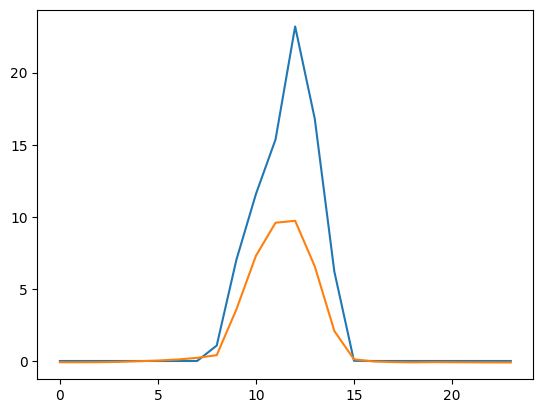

In [266]:
plt.plot(y_true)
plt.plot(y_pred[0])

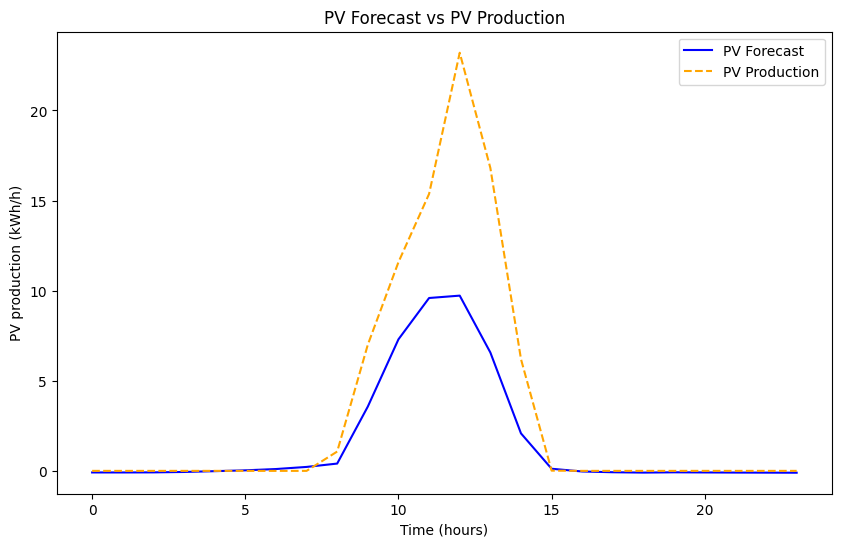

In [267]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the 'pv_forecast' column
plt.plot(y_pred[0], label='PV Forecast', color='blue', linestyle='-')

# Plot the 'pv_production' column
plt.plot(y_true, label='PV Production', color='orange', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('PV production (kWh/h)')
plt.title('PV Forecast vs PV Production')
plt.legend()

# Display the plot
plt.show()

In [274]:
df = test_data[['consumption', 'spot_market_price']][:24]

In [277]:
df['total_electricity_price'] = df['consumption'] * df['spot_market_price']

In [298]:
def total_electricity_cost():
    '''
    Output how much electricity cost the Norwegian grid would face if they would not have any pv_production nor any solar_production.
    Provide graphs on the website on the electricity cost across the time period.

    Make use of
    - total_electricity_cost()
    '''
    
    df = pd.read_csv("/Users/carlbechtolsheim/code/Niki827/watt_squad/raw_data/test.csv")
    df = df[['consumption', 'spot_market_price']][:24]
    df['total_electricity_price'] = df['consumption'] * df['spot_market_price']
    
    return df['total_electricity_price']

In [299]:
total_electricity_cost()

0     16.062949
1     16.709976
2     15.579186
3     15.812658
4     19.265014
5     24.894546
6     40.915775
7     93.786656
8     88.056589
9     64.166155
10    32.332704
11    23.596508
12    23.928918
13    36.299454
14    42.945828
15    71.964318
16    95.885864
17    45.652059
18    36.450849
19    53.204493
20    28.008868
21    31.026456
22    20.918201
23    15.894032
Name: total_electricity_price, dtype: float64

In [300]:
df = test_data[:24]
total_electricity_cost = total_electricity_cost()

total_electricity_prod = df['pv_production'] + df['wind_production']

In [302]:
total_electricity_prod - total_electricity_cost

0     12.957051
1     10.380024
2     24.980814
3     21.907342
4     28.714986
5     32.585454
6     21.674225
7    -13.166656
8      0.575244
9     10.737095
10    61.889462
11    53.731326
12    29.152582
13     8.359379
14   -10.486578
15   -25.322018
16   -45.595864
17     1.967941
18    14.409151
19     2.445507
20    17.131132
21    18.303544
22    19.821799
23    23.295968
dtype: float64

In [284]:
df

,time,pv_production,wind_production,consumption,spot_market_price,precip_1h:mm,precip_type:idx,prob_precip_1h:p,clear_sky_rad:W,clear_sky_energy_1h:J,...,t_50m:C,relative_humidity_50m:p,dew_point_50m:C,wind_speed_50m:ms,wind_dir_50m:d,t_100m:C,relative_humidity_100m:p,dew_point_100m:C,wind_speed_100m:ms,wind_dir_100m:d
0,2021-02-01 00:00:00,0.0,29.02,37.731253,0.42572,0.0,0.0,1.0,0.0,0.0,...,-4.3,91.9,-5.4,4.0,213.8,-3.7,88.8,-5.3,5.1,223.2
1,2021-02-01 01:00:00,0.0,27.09,39.288933,0.42531,0.0,0.0,1.0,0.0,0.0,...,-4.6,91.5,-5.8,4.0,205.6,-4.0,87.8,-5.7,5.1,214.8
2,2021-02-01 02:00:00,0.0,40.56,37.472487,0.41575,0.0,0.0,1.0,0.0,0.0,...,-4.9,91.2,-6.1,4.3,203.8,-4.1,86.9,-5.9,5.6,212.1
3,2021-02-01 03:00:00,0.0,37.72,37.343327,0.42344,0.0,0.0,1.0,0.0,0.0,...,-5.2,89.9,-6.6,4.3,201.7,-4.3,85.0,-6.4,5.6,210.4
4,2021-02-01 04:00:00,0.0,47.98,38.386463,0.50187,0.0,0.0,1.0,0.0,0.0,...,-5.6,88.3,-7.2,4.0,194.6,-4.5,82.4,-7.0,5.0,201.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,2021-03-07 20:00:00,0.0,-0.36,45.174683,0.28008,0.0,0.0,1.0,0.0,0.0,...,-1.2,86.0,-3.2,4.5,268.9,-1.5,86.1,-3.5,5.4,274.8
837,2021-03-07 21:00:00,0.0,4.20,42.956577,0.28772,0.0,0.0,1.0,0.0,0.0,...,-1.4,86.5,-3.4,4.1,260.6,-1.7,86.1,-3.7,5.0,266.6
838,2021-03-07 22:00:00,0.0,13.24,33.505287,0.28761,0.0,0.0,1.0,0.0,0.0,...,-1.9,86.5,-3.8,3.8,252.3,-2.1,85.5,-4.2,4.7,258.2
839,2021-03-07 23:00:00,0.0,23.88,30.679047,0.27743,0.0,0.0,1.0,0.0,0.0,...,-2.5,88.4,-4.1,3.7,236.9,-2.7,87.1,-4.5,4.7,244.9


## Cross Validation

### Sequences

In [ ]:
def get_Xi_yi(
    df:pd.DataFrame,
    input_length:int,  # 120
    output_length:int):  # 120
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    # YOUR CODE
    first_possible_start = 0                                    # the +1 accounts for the index, that is exclusive.
    last_possible_start = len(df) - (input_length + output_length) + 1    # It can start as long as there are still
                                                                             # 120 + 1 days after the 1st day.
    random_start = np.random.randint(first_possible_start, last_possible_start)  # np.random to pick a day inside
                                                                                    # the possible interval.
    X_i = df.iloc[random_start:random_start+input_length]

    y_i = df.iloc[random_start+input_length:
                  random_start+input_length+output_length][TARGET]  # creates a pd.DataFrame for the target y

    return (X_i, y_i)

In [ ]:
#Testing if the function works
Xi, Yi = get_Xi_yi(
    fold=folds[0],
    input_length=INPUT_LENGTH,
    output_length=OUTPUT_LENGTH)

In [ ]:
Xi.shape

(120, 53)

In [ ]:
### In the recap they choose a number which is bigger than the number of rows in the fold -> does that mean there are duplications???!!!
NUMBER_OF_SEQUENCES_TRAIN = (FOLD_LENGTH - (INPUT_LENGTH + OUTPUT_LENGTH))
NUMBER_OF_SEQUENCES_VAL = (FOLD_LENGTH - (INPUT_LENGTH + OUTPUT_LENGTH))

In [ ]:
NUMBER_OF_SEQUENCES_TRAIN = len(df) - (INPUT_LENGTH + OUTPUT_LENGTH)

In [ ]:
NUMBER_OF_SEQUENCES_TRAIN

9383

In [ ]:
def get_X_y(
    df:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int
):
    # YOUR CODE HERE
    X, y = [], []  # lists for the sequences for X and y

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(df, input_length, output_length)   # calls the previous function to generate sequences X + y
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)

In [ ]:
seq = get_X_y(df, NUMBER_OF_SEQUENCES_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
seq[1].shape

(9383, 12, 3)

In [ ]:
X_train.shape

(2556, 120, 53)

In [ ]:
y_train.shape

(2556, 12, 3)

In [ ]:
y_temp = y_train[:,:,0]

In [ ]:
y_temp = np.expand_dims(y_temp, axis=-1)

In [ ]:
y_temp.shape

(2556, 12, 1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates
    - the "last seen value" baseline model
    - the RNN model
    '''

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)  # function we coded to get the folds

    for fold_id, fold in enumerate(folds):

        # 1 - Train/val split the current fold
        # =========================================
        (fold_train, fold_val) = train_val_split(fold, TRAIN_VAL_RATIO, INPUT_LENGTH) # function we coded to split train/val

        X_train, y_train = get_X_y(fold_train, NUMBER_OF_SEQUENCES_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)  # function we coded to get multiple
        X_val, y_val = get_X_y(fold_val, NUMBER_OF_SEQUENCES_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)       # sequences from a fold

        # 2 - Modelling
        # =========================================

        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_val, y_val, verbose=0)[1]   # evaluating baseline model (metric)
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 3,
                           restore_best_weights = True)

        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_val, y_val, verbose=0)    # evaluating LSTM (metric)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [ ]:
###NOT IMPORTANT NOW

fold_length = 24 * 7 * 16    # 24 hours * 7 days * 16 weeks (4 months)
fold_stride = 24 * 7 * 2     # 24 hours * 7 days * 2 weeks
train_test_ratio = 0.66

In [ ]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Returns a list of folds, each as a DataFrame
    '''
    # YOUR CODE HERE
    folds = []
    for idx in range(0, len(df)-fold_length, fold_stride): # --> also possible to get rid of the break
    #for idx in range(0, len(df), fold_stride):   # range(start, stop, step): for each idx in our rows at every 91 days
        # Exits the loop as soon as the last fold index would exceed the last index
        #if (idx + fold_length) > len(df):
            #break
        fold = df.iloc[idx:idx + fold_length, :]  # select from row idx til last row of the fold (3 years), all the columns
        folds.append(fold)   # append the 3 year fold to folds
    return folds